In [2]:
# 1. Kalman_Filter Class

def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

In [3]:
# 2. Implementing the Kalman Model

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt

import datetime
import pandas_datareader as web

In [4]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)
df_pfe = web.DataReader('PFE', 'yahoo', start, end) 
pfe= df_pfe
pfe=pfe.reset_index()
pfe['Date'] = pd.to_datetime(pfe['Date'])
pfe['Typical_Price'] = pfe[['High','Low','Close']].mean(axis=1)
pfe['lrets'] = (np.log(pfe.Close) - np.log(pfe.Close.shift(1))) * 100.
pfe.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Typical_Price,lrets
0,2014-01-02,29.032257,28.776091,28.908918,28.899431,18366266.0,22.159529,28.902593,NaN
1,2014-01-03,29.250475,28.823528,28.833017,28.956356,15847312.0,22.203180,29.010120,0.196782
2,2014-01-06,29.364326,28.965843,29.193548,28.984819,25255421.0,22.225004,29.104996,0.098249
3,2014-01-07,29.430740,29.165085,29.278936,29.165085,23423042.0,22.363232,29.253637,0.620004
4,2014-01-08,29.402277,29.079697,29.203035,29.364326,24161053.0,22.515999,29.282100,0.680828


F:\anaconda\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


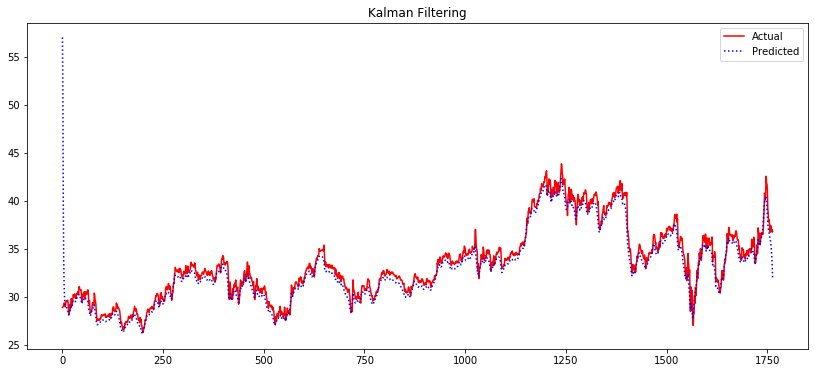

,Actual,Predicted,Open,Close
Date,,,,
2014-01-02,28.899431,57.021315,28.908918,28.899431
2014-01-03,28.956356,51.388877,28.833017,28.956356
2014-01-06,28.984819,40.121733,29.193548,28.984819
2014-01-07,29.165085,34.305827,29.278936,29.165085
2014-01-08,29.364326,31.420641,29.203035,29.364326
2014-01-09,29.345350,29.985111,29.487665,29.345350
2014-01-10,29.117647,29.289700,29.259962,29.117647
2014-01-13,28.975332,29.037638,29.278936,28.975332
2014-01-14,29.411764,29.043243,29.013283,29.411764


In [5]:
Y = pfe['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, y_pred,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(y_pred),
                  'Date':pfe['Date'],
                  'Open':pfe['Open'],
                  'Close':pfe['Close']
                       })


results.set_index('Date',inplace = True)
results.head(10)

[28.899431228637695,
 28.956356048583984,
 28.984819412231445,
 29.165084838867188,
 29.36432647705078,
 29.34535026550293,
 29.117647171020508,
 28.975332260131836,
 29.41176414489746,
 29.582542419433594,
 29.573055267333984,
 29.497154235839844,
 29.629980087280273,
 29.667932510375977,
 29.42125129699707,
 28.54838752746582,
 28.140417098999023,
 28.861480712890625,
 28.56736183166504,
 29.24098777770996,
 28.842504501342773,
 29.032257080078125,
 29.829221725463867,
 29.079696655273438,
 29.25996208190918,
 29.620492935180664,
 29.857685089111328,
 30.246679306030273,
 29.99051284790039,
 30.07590103149414,
 30.303604125976562,
 30.246679306030273,
 29.867172241210938,
 29.93358612060547,
 29.84819793701172,
 30.351043701171875,
 30.256166458129883,
 30.351043701171875,
 30.57874870300293,
 30.464895248413086,
 30.341556549072266,
 31.015180587768555,
 31.072105407714844,
 30.796964645385742,
 30.76850128173828,
 30.73055076599121,
 30.75901222229004,
 30.341556549072266,
 29.5256

In [10]:
from sklearn.metrics import r2_score
r2_score(list(results['Actual']), list(y_pred['Predicted']))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# 3.1 Long Short Day trading:
* if predicted > yesterdays close, buy and sell at end of day

* if predicted < yesterdays close, sell and buy at end of day

0 Buy at Open 9973.58 345 0
0 Sell at Close 9970.3 0


1 Buy at Open 9947.39 345 9
1 Sell at Close 9998.94 0


2 Buy at Open 9984.19 342 28
2 Sell at Close 9940.81 0


3 Buy at Open 9925.56 339 24
3 Sell at Close 9910.96 0


4 Buy at Open 9899.83 339 15
4 Sell at Close 9969.51 0


5 Buy at Open 9966.83 338 21
5 Sell at Close 9939.73 0


6 Sell at Open 9919.13 - 339 10
6 Buy Back at Close 9880.88 0


7 Sell at Open 9867.0 - 337 0
7 Buy Back at Close 9764.69 0


8 Buy at Open 9748.46 336 29
8 Sell at Close 9911.35 0


9 Sell at Open 9898.29 - 336 1
9 Buy Back at Close 9940.73 0


10 Sell at Open 9939.73 - 336 4
10 Buy Back at Close 9940.55 0


11 Sell at Open 9932.4 - 335 0
11 Buy Back at Close 9881.55 0


12 Sell at Open 9865.5 - 332 14
12 Buy Back at Close 9851.15 0


13 Sell at Open 9832.65 - 331 1
13 Buy Back at Close 9821.09 0


14 Sell at Open 9800.44 - 333 23
14 Buy Back at Close 9820.28 0


15 Sell at Open 9808.44 - 335 28
15 Buy Back at Close 9591.71 0


16 Sell at Open 9576.32 

183 Buy Back at Close 8058.99 0


184 Sell at Open 8057.31 - 280 9
184 Buy Back at Close 7973.33 0


185 Sell at Open 7961.67 - 280 21
185 Buy Back at Close 7916.26 0


186 Sell at Open 7910.12 - 281 7
186 Buy Back at Close 7943.78 0


187 Sell at Open 7936.78 - 281 4
187 Buy Back at Close 7887.46 0


188 Sell at Open 7885.87 - 283 5
188 Buy Back at Close 7831.8 0


189 Sell at Open 7829.49 - 283 1
189 Buy Back at Close 7803.64 0


190 Sell at Open 7781.02 - 280 13
190 Buy Back at Close 7775.43 0


191 Sell at Open 7769.12 - 279 26
191 Buy Back at Close 7747.47 0


192 Sell at Open 7739.5 - 281 17
192 Buy Back at Close 7692.51 0


193 Sell at Open 7680.84 - 281 26
193 Buy Back at Close 7858.81 0


194 Sell at Open 7838.14 - 281 19
194 Buy Back at Close 7747.83 0


195 Sell at Open 7733.21 - 280 9
195 Buy Back at Close 7747.52 0


196 Sell at Open 7746.49 - 280 22
196 Buy Back at Close 7585.19 0


197 Sell at Open 7581.18 - 279 24
197 Buy Back at Close 7557.53 0


198 Sell at Open 7542.

320 Buy Back at Close 9566.87 0


321 Sell at Open 9543.98 - 287 28
321 Buy Back at Close 9566.53 0


322 Sell at Open 9538.52 - 284 12
322 Buy Back at Close 9499.32 0


323 Sell at Open 9482.88 - 285 17
323 Buy Back at Close 9532.32 0


324 Sell at Open 9530.36 - 287 24
324 Buy Back at Close 9565.25 0


325 Sell at Open 9541.25 - 287 32
325 Buy Back at Close 9565.08 0


326 Sell at Open 9557.59 - 287 31
326 Buy Back at Close 9531.41 0


327 Sell at Open 9514.38 - 288 20
327 Buy Back at Close 9564.44 0


328 Sell at Open 9533.51 - 288 3
328 Buy Back at Close 9664.94 0


329 Sell at Open 9651.61 - 289 27
329 Buy Back at Close 9697.81 0


330 Sell at Open 9690.0 - 289 16
330 Buy Back at Close 9500.35 0


331 Sell at Open 9492.52 - 288 13
331 Buy Back at Close 9434.48 0


332 Sell at Open 9434.03 - 291 32
332 Buy Back at Close 9499.16 0


333 Sell at Open 9482.19 - 293 2
333 Buy Back at Close 9434.15 0


334 Sell at Open 9412.69 - 293 24
334 Buy Back at Close 9497.85 0


335 Sell at Open 

474 Sell at Open 8474.0 - 270 22
474 Buy Back at Close 8554.92 0


475 Sell at Open 8524.16 - 274 7
475 Buy Back at Close 8401.17 0


476 Sell at Open 8376.83 - 271 5
476 Buy Back at Close 8278.98 0


477 Sell at Open 8257.44 - 277 15
477 Buy Back at Close 8248.79 0


478 Buy at Open 8246.93 277 28
478 Sell at Close 8429.98 0


479 Buy at Open 8412.37 274 9
479 Sell at Close 8553.95 0


480 Sell at Open 8526.72 - 273 29
480 Buy Back at Close 8522.05 0


481 Sell at Open 8492.9 - 272 3
481 Buy Back at Close 8459.77 0


482 Sell at Open 8453.51 - 270 6
482 Buy Back at Close 8618.33 0


483 Sell at Open 8593.2 - 269 3
483 Buy Back at Close 8399.68 0


484 Sell at Open 8370.55 - 268 10
484 Buy Back at Close 8245.79 0


485 Sell at Open 8230.39 - 267 30
485 Buy Back at Close 8338.92 0


486 Sell at Open 8324.78 - 268 3
486 Buy Back at Close 8307.44 0


487 Sell at Open 8287.0 - 270 5
487 Buy Back at Close 8338.11 0


488 Sell at Open 8335.69 - 271 5
488 Buy Back at Close 8307.27 0


489 Sel

639 Sell at Open 9329.15 - 268 8
639 Buy Back at Close 9324.43 0


640 Sell at Open 9324.06 - 268 8
640 Buy Back at Close 9324.43 0


641 Sell at Open 9312.52 - 266 32
641 Buy Back at Close 9289.0 0


642 Sell at Open 9254.48 - 266 24
642 Buy Back at Close 9288.57 0


643 Sell at Open 9287.29 - 266 16
643 Buy Back at Close 9288.14 0


644 Sell at Open 9287.29 - 266 5
644 Buy Back at Close 9287.24 0


645 Sell at Open 9259.91 - 265 27
645 Buy Back at Close 9286.91 0


646 Sell at Open 9274.67 - 266 21
646 Buy Back at Close 9320.9 0


647 Sell at Open 9307.48 - 266 31
647 Buy Back at Close 9285.48 0


648 Sell at Open 9257.0 - 266 10
648 Buy Back at Close 9320.0 0


649 Sell at Open 9307.69 - 265 10
649 Buy Back at Close 9390.6 0


650 Sell at Open 9381.82 - 269 34
650 Buy Back at Close 9321.39 0


651 Sell at Open 9301.17 - 273 13
651 Buy Back at Close 9153.58 0


652 Sell at Open 9127.61 - 271 15
652 Buy Back at Close 9052.62 0


653 Sell at Open 9024.52 - 269 7
653 Buy Back at Close 9

826 Sell at Open 7682.47 - 239 11
826 Buy Back at Close 7693.47 0


827 Sell at Open 7687.0 - 239 16
827 Buy Back at Close 7725.68 0


828 Sell at Open 7719.32 - 241 20
828 Buy Back at Close 7757.61 0


829 Sell at Open 7739.9 - 241 8
829 Buy Back at Close 7693.02 0


830 Sell at Open 7689.59 - 241 10
830 Buy Back at Close 7724.74 0


831 Sell at Open 7723.8 - 242 0
831 Buy Back at Close 7723.8 0


832 Sell at Open 7705.14 - 239 9
832 Buy Back at Close 7659.72 0


833 Sell at Open 7636.77 - 238 4
833 Buy Back at Close 7627.23 0


834 Sell at Open 7613.68 - 237 15
834 Buy Back at Close 7626.43 0


835 Sell at Open 7603.95 - 236 12
835 Buy Back at Close 7593.56 0


836 Sell at Open 7586.03 - 236 30
836 Buy Back at Close 7624.99 0


837 Sell at Open 7620.43 - 237 29
837 Buy Back at Close 7624.69 0


838 Sell at Open 7614.44 - 239 3
838 Buy Back at Close 7624.24 0


839 Sell at Open 7623.53 - 240 2
839 Buy Back at Close 7623.25 0


840 Sell at Open 7614.42 - 240 6
840 Buy Back at Close 762

986 Buy Back at Close 8416.16 0


987 Sell at Open 8401.1 - 244 1
987 Buy Back at Close 8415.99 0


988 Sell at Open 8412.78 - 243 33
988 Buy Back at Close 8346.64 0


989 Sell at Open 8315.45 - 244 30
989 Buy Back at Close 8278.31 0


990 Sell at Open 8270.49 - 245 12
990 Buy Back at Close 8277.84 0


991 Sell at Open 8265.84 - 245 25
991 Buy Back at Close 8276.9 0


992 Buy at Open 8243.57 246 3
992 Sell at Close 8344.59 0


993 Buy at Open 8343.23 244 30
993 Sell at Close 8412.58 0


994 Sell at Open 8382.81 - 243 13
994 Buy Back at Close 8446.53 0


995 Sell at Open 8431.22 - 243 33
995 Buy Back at Close 8480.36 0


996 Sell at Open 8468.11 - 243 5
996 Buy Back at Close 8410.86 0


997 Sell at Open 8409.85 - 241 10
997 Buy Back at Close 8515.88 0


998 Sell at Open 8510.45 - 241 26
998 Buy Back at Close 8515.88 0


999 Sell at Open 8505.88 - 241 34
999 Buy Back at Close 8480.43 0


1000 Sell at Open 8457.86 - 241 5
1000 Buy Back at Close 8341.68 0


1001 Sell at Open 8320.3 - 240 2

1181 Sell at Open 10240.99 - 257 3
1181 Buy Back at Close 10319.57 0


1182 Sell at Open 10314.14 - 257 18
1182 Buy Back at Close 10358.96 0


1183 Sell at Open 10322.58 - 256 32
1183 Buy Back at Close 10439.59 0


1184 Sell at Open 10423.86 - 257 5
1184 Buy Back at Close 10480.07 0


1185 Sell at Open 10448.88 - 256 33
1185 Buy Back at Close 10479.45 0


1186 Sell at Open 10444.02 - 256 35
1186 Buy Back at Close 10602.89 0


1187 Sell at Open 10587.23 - 257 13
1187 Buy Back at Close 10561.22 0


1188 Sell at Open 10533.89 - 256 18
1188 Buy Back at Close 10644.19 0


1189 Sell at Open 10633.47 - 256 26
1189 Buy Back at Close 10727.48 0


1190 Sell at Open 10714.02 - 257 15
1190 Buy Back at Close 10726.58 0


1191 Sell at Open 10718.48 - 256 7
1191 Buy Back at Close 10642.9 0


1192 Sell at Open 10606.45 - 255 33
1192 Buy Back at Close 10600.74 0


1193 Sell at Open 10594.35 - 255 21
1193 Buy Back at Close 10641.97 0


1194 Sell at Open 10628.23 - 255 21
1194 Buy Back at Close 10683.1 0

1352 Sell at Open 10853.98 - 277 10
1352 Buy Back at Close 10908.66 0


1353 Sell at Open 10880.27 - 277 17
1353 Buy Back at Close 10947.2 0


1354 Sell at Open 10922.16 - 276 35
1354 Buy Back at Close 10946.69 0


1355 Sell at Open 10916.93 - 276 30
1355 Buy Back at Close 11025.48 0


1356 Sell at Open 10995.9 - 277 8
1356 Buy Back at Close 11024.93 0


1357 Sell at Open 11013.81 - 276 0
1357 Buy Back at Close 10985.01 0


1358 Sell at Open 10957.4 - 274 13
1358 Buy Back at Close 10905.41 0


1359 Sell at Open 10879.98 - 275 20
1359 Buy Back at Close 10905.2 0


1360 Sell at Open 10874.76 - 275 12
1360 Buy Back at Close 10944.16 0


1361 Sell at Open 10916.93 - 276 32
1361 Buy Back at Close 10904.41 0


1362 Buy at Open 10901.21 276 6
1362 Sell at Close 10983.15 0


1363 Sell at Open 10962.58 - 272 4
1363 Buy Back at Close 10902.06 0


1364 Sell at Open 10872.3 - 269 20
1364 Buy Back at Close 10861.67 0


1365 Sell at Open 10842.13 - 267 1
1365 Buy Back at Close 10820.33 0


1366 Sell

1471 Buy Back at Close 9114.3 0


1472 Sell at Open 9099.19 - 255 15
1472 Buy Back at Close 9114.19 0


1473 Sell at Open 9083.87 - 256 9
1473 Buy Back at Close 8973.86 0


1474 Sell at Open 8957.57 - 256 10
1474 Buy Back at Close 9008.86 0


1475 Sell at Open 8999.88 - 257 4
1475 Buy Back at Close 9008.75 0


1476 Sell at Open 8980.37 - 257 29
1476 Buy Back at Close 9043.51 0


1477 Sell at Open 9009.63 - 257 15
1477 Buy Back at Close 8939.29 0


1478 Sell at Open 8914.54 - 257 27
1478 Buy Back at Close 8939.1 0


1479 Buy at Open 8931.6 257 25
1479 Sell at Close 9115.09 0


1480 Sell at Open 9081.44 - 256 4
1480 Buy Back at Close 9044.15 0


1481 Sell at Open 9020.13 - 254 4
1481 Buy Back at Close 9079.56 0


1482 Sell at Open 9053.87 - 254 10
1482 Buy Back at Close 8938.56 0


1483 Buy at Open 8931.81 253 22
1483 Sell at Close 9081.03 0


1484 Sell at Open 9071.03 - 253 25
1484 Buy Back at Close 9225.65 0


1485 Sell at Open 9200.15 - 252 14
1485 Buy Back at Close 9261.97 0


1486 S

1658 Sell at Open 7923.7 - 218 8
1658 Buy Back at Close 7948.25 0


1659 Sell at Open 7920.29 - 217 32
1659 Buy Back at Close 7948.18 0


1660 Sell at Open 7945.27 - 216 32
1660 Buy Back at Close 7874.81 0


1661 Sell at Open 7848.96 - 216 31
1661 Buy Back at Close 7910.7 0


1662 Sell at Open 7900.19 - 216 6
1662 Buy Back at Close 7873.4 0


1663 Sell at Open 7865.65 - 215 21
1663 Buy Back at Close 7729.59 0


1664 Sell at Open 7716.75 - 215 19
1664 Buy Back at Close 7837.74 0


1665 Sell at Open 7801.82 - 216 15
1665 Buy Back at Close 7837.31 0


1666 Sell at Open 7825.59 - 217 1
1666 Buy Back at Close 7836.88 0


1667 Sell at Open 7831.77 - 217 14
1667 Buy Back at Close 7909.59 0


1668 Sell at Open 7879.7 - 216 11
1668 Buy Back at Close 7872.25 0


1669 Sell at Open 7849.34 - 215 31
1669 Buy Back at Close 7835.46 0


1670 Sell at Open 7824.36 - 216 10
1670 Buy Back at Close 7945.03 0


1671 Sell at Open 7937.05 - 215 14
1671 Buy Back at Close 7944.93 0


1672 Sell at Open 7922.47 -

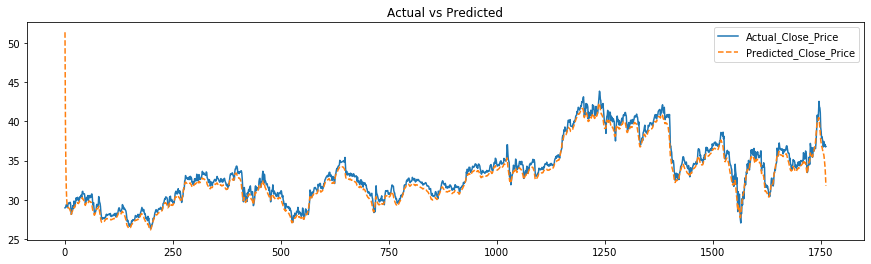

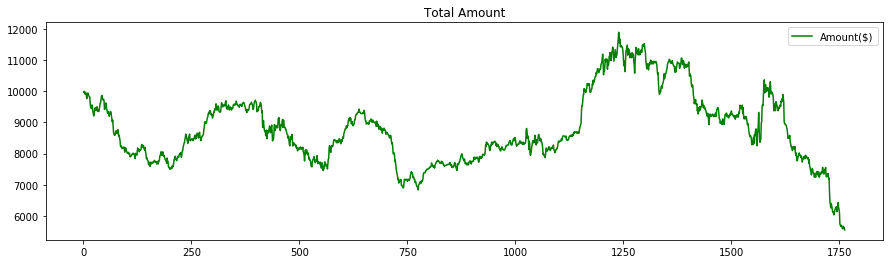

In [23]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)-1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
        
    else:
        action.append('Sell at Open & Bull at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
        Portfolio.append(round(portfolio,5))
    print('\n')
        

Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [24]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 5552.740253448486 $
Profit_Percent: 55.52740253448486 %


# 3.2 Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [25]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['Actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['Actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 28.899431228637695 Action: Buy Portfolio: 9999.2 Stocks: 346 Balance_init: 0 total($) 9999.2


Stock: 28.956356048583984 Action: Bought--Holding Portfolio: 10018.9 Stocks: 346 Balance_init: 0 total($) 10018.9


Stock: 28.984819412231445 Action: Bought--Holding Portfolio: 10028.75 Stocks: 346 Balance_init: 0 total($) 10028.75


Stock: 29.165084838867188 Action: Bought--Holding Portfolio: 10091.12 Stocks: 346 Balance_init: 0 total($) 10091.12


Stock: 29.36432647705078 Action: Bought--Holding Portfolio: 10160.06 Stocks: 346 Balance_init: 0 total($) 10160.06


Stock: 29.34535026550293 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10153.49


Stock: 29.117647171020508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10153.49


Stock: 28.975332260131836 Action: Buy Portfolio: 10141.37 Stocks: 350 Balance_init: 12 total($) 10153.37


Stock: 29.41176414489746 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10306.12


Stoc

Stock: 28.092979431152344 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.0834903717041 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.111953735351562 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.187856674194336 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.074003219604492 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.121442794799805 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 28.235294342041016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 27.91271209716797 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11959.81


Stock: 27.8

Stock: 28.766603469848633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13454.98


Stock: 29.022769927978516 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13454.98


Stock: 28.880455017089844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13454.98


Stock: 28.880455017089844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13454.98


Stock: 28.889942169189453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13454.98


Stock: 28.67172622680664 Action: Buy Portfolio: 13447.04 Stocks: 469 Balance_init: 7 total($) 13454.04


Stock: 28.908918380737305 Action: Bought--Holding Portfolio: 13558.28 Stocks: 469 Balance_init: 7 total($) 13565.28


Stock: 29.506641387939453 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13845.61


Stock: 29.554079055786133 Action: Price-Prediction-Already-

Stock: 32.2296028137207 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.286529541015625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.04933547973633 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 31.907020568847656 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.25806427001953 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.25806427001953 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.67552185058594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.41935348510742 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16444.99


Stock: 32.61859

Stock: 33.43453598022461 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17134.8


Stock: 33.339656829833984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17134.8


Stock: 33.092979431152344 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17134.8


Stock: 32.99810028076172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17134.8


Stock: 32.50474548339844 Action: Buy Portfolio: 17130.0 Stocks: 527 Balance_init: 4 total($) 17134.0


Stock: 32.58064651489258 Action: Bought--Holding Portfolio: 17170.0 Stocks: 527 Balance_init: 4 total($) 17174.0


Stock: 33.53889846801758 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17679.0


Stock: 33.927894592285156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 17679.0


Stock: 33.89942932128906 Action: Price-Prediction-Already-Lower Portfolio


Stock: 30.531309127807617 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23642.27


Stock: 29.724857330322266 Action: Buy Portfolio: 23631.26 Stocks: 795 Balance_init: 11 total($) 23642.26


Stock: 30.332067489624023 Action: Bought--Holding Portfolio: 24113.99 Stocks: 795 Balance_init: 11 total($) 24124.99


Stock: 31.185958862304688 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24803.84


Stock: 31.110057830810547 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24803.84


Stock: 31.091081619262695 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24803.84


Stock: 31.897533416748047 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24803.84


Stock: 31.214420318603516 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 24803.84


Stock: 30.73055076599121 Action: Price-Prediction-Alrea

Stock: 28.823528289794922 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26664.47


Stock: 28.643264770507812 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26664.47


Stock: 28.538898468017578 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26664.47


Stock: 28.254268646240234 Action: Buy Portfolio: 26643.78 Stocks: 943 Balance_init: 20 total($) 26663.78


Stock: 28.510435104370117 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26905.34


Stock: 28.52941131591797 Action: Buy Portfolio: 26903.23 Stocks: 943 Balance_init: 2 total($) 26905.23


Stock: 28.121442794799805 Action: Bought--Holding Portfolio: 26518.52 Stocks: 943 Balance_init: 2 total($) 26520.52


Stock: 28.50094985961914 Action: Bought--Holding Portfolio: 26876.4 Stocks: 943 Balance_init: 2 total($) 26878.4


Stock: 29.14611053466797 Action: Bought--Holding Portfolio: 27484.78 Stocks: 943 Bala

Stock: 34.85768508911133 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 34.89563751220703 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 34.94307327270508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 34.9620475769043 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 34.7912712097168 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 35.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 35.39848327636719 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 34.52561569213867 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32809.51


Stock: 33.481971740722656 Actio

Stock: 31.869070053100586 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.31499099731445 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.50474548339844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.523719787597656 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.371917724609375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.65654754638672 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.74193572998047 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.75142288208008 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 32.590

Stock: 31.034156799316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 30.872865676879883 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 30.69260025024414 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 30.426944732666016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 30.360530853271484 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 38541.32


Stock: 30.123340606689453 Action: Buy Portfolio: 38527.75 Stocks: 1279 Balance_init: 13 total($) 38540.75


Stock: 31.091081619262695 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 39778.49


Stock: 31.024667739868164 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 39778.49


Stock: 30.910816192626953 Action: Price-Prediction-


Stock: 33.263755798339844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.45351028442383 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.64326477050781 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.72865295410156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.51043701171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.54838562011719 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.52941131591797 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.396583557128906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 41704.88


Stock: 33.377

Stock: 33.927894592285156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 47711.68


Stock: 33.90891647338867 Action: Buy Portfolio: 47709.85 Stocks: 1407 Balance_init: 1 total($) 47710.85


Stock: 34.402278900146484 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 35.189754486083984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 34.91461181640625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 34.44971466064453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 33.8045539855957 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 34.108158111572266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 48405.01


Stock: 34.26945114135742 Action: Price-Prediction-Alread

Stock: 34.08918380737305 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.39278793334961 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.582542419433594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.573055267333984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.51612854003906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.6204948425293 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.7912712097168 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.44022750854492 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 51169.24


Stock: 34.440227

Stock: 42.00189971923828 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 41.95446014404297 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 42.51423263549805 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 42.40986633300781 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 42.609107971191406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 42.96015167236328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 43.14041519165039 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 42.2296028137207 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57572.52


Stock: 40.616699

Stock: 40.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 69714.21


Stock: 38.851993560791016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 69714.21


Stock: 38.55787658691406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 69714.21


Stock: 37.50474548339844 Action: Buy Portfolio: 69683.82 Stocks: 1858 Balance_init: 30 total($) 69713.82


Stock: 38.68121337890625 Action: Bought--Holding Portfolio: 71869.69 Stocks: 1858 Balance_init: 30 total($) 71899.69


Stock: 39.44971466064453 Action: Bought--Holding Portfolio: 73297.57 Stocks: 1858 Balance_init: 30 total($) 73327.57


Stock: 40.275142669677734 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 74861.22


Stock: 40.68311309814453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 74861.22


Stock: 40.265655517578125 Action: Price-Prediction-Already-Lower Portfolio: 0

Stock: 38.57685089111328 Action: Buy Portfolio: 81474.31 Stocks: 2112 Balance_init: 21 total($) 81495.31


Stock: 39.041744232177734 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.50664138793945 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.34535217285156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.45920181274414 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.53510284423828 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.83871078491211 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.77229690551758 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 82477.16


Stock: 39.800758361816406 Action: Price-Prediction-Alread

Stock: 34.94307327270508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 35.46489715576172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 35.49335861206055 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 35.370018005371094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 35.01897430419922 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 34.94307327270508 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 34.629981994628906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 34.51612854003906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90124.47


Stock: 34.6394

Stock: 38.62428665161133 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 37.779884338378906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 38.10246658325195 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 36.18595886230469 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 35.65464782714844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 35.1707763671875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 35.332069396972656 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock: 35.588233947753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 105885.56


Stock:

Stock: 36.50853729248047 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.38520050048828 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.42314910888672 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.48007583618164 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.30929946899414 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.48007583618164 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 36.42314910888672 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 35.85388946533203 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 252763.51


Stock: 3

In [26]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,28.956356,51.388877,2014-01-03,Buy,346,9999.20321,9999.0
2,28.984819,40.121733,2014-01-06,Bought--Holding,346,10018.89919,10019.0
3,29.165085,34.305827,2014-01-07,Bought--Holding,346,10028.74752,10029.0
4,29.364326,31.420641,2014-01-08,Bought--Holding,346,10091.11935,10091.0
5,29.345350,29.985111,2014-01-09,Bought--Holding,346,10160.05696,10160.0


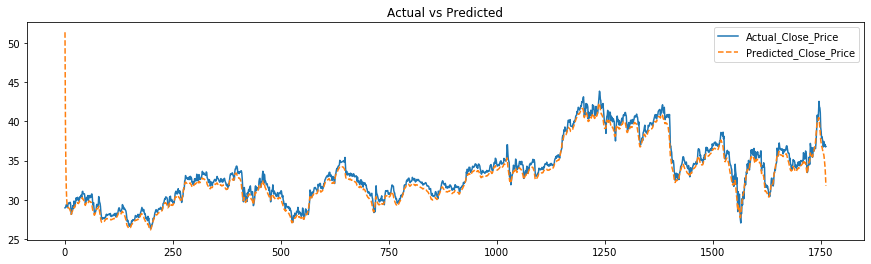

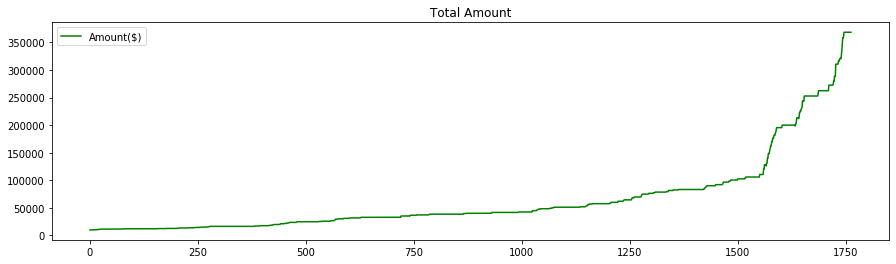

In [27]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [28]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 368364.0 $
Profit_Percent: 3683.64 %


 Model evaluaion

* rmse

In [40]:
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

sqrt(rms)

0.9860898248910612

# Buy & Hold Trading Strategy with bollinger bands

In [31]:
long_MA = results['Actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [32]:
short_MA  = results['Actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [33]:
long_std= results['Actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [34]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [35]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

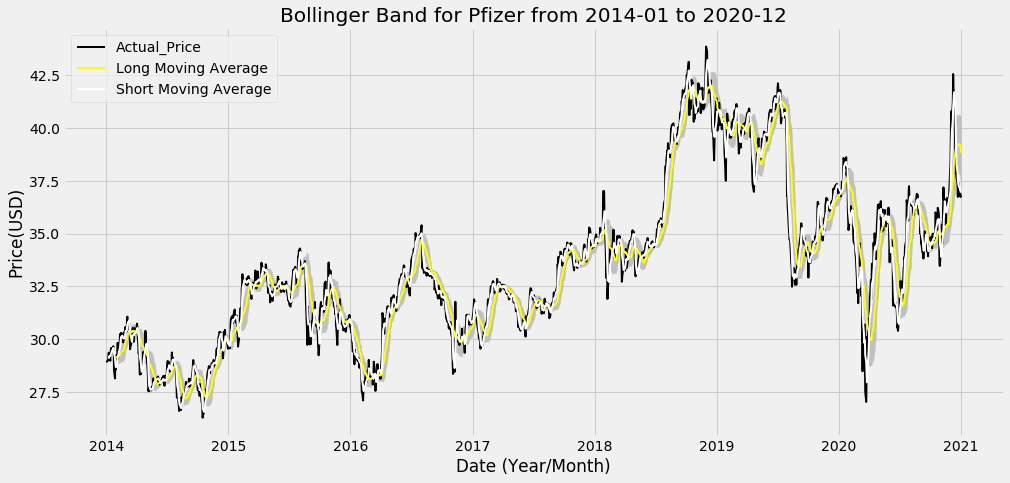

In [36]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='silver')
ax.plot(x_axis, results['Actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='white', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Pfizer from 2014-01 to 2020-12')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

In [37]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i] > results['Long_Lower_Band'][i]:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i] < results['Long_Moving_Avg'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Do nothing')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')
    

Strategy_Result = pd.DataFrame({'Actual_Close_Price':pfe.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': pfe.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

Stock: 28.899431228637695 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.956356048583984 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.984819412231445 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.165084838867188 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.36432647705078 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.34535026550293 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.117647171020508 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 28.975332260131836 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.41176414489746 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 29.582542419433594 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 1

Stock: 28.092979431152344 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.0834903717041 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.111953735351562 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.187856674194336 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.074003219604492 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.121442794799805 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 28.235294342041016 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 27.91271209716797 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10943.22


Stock: 27.8

Stock: 30.218215942382812 Action: Bought--Holding Portfolio: 13326.23 Stocks: 441 Balance_init: 7 total($) 13333.23


Stock: 30.834915161132812 Action: Bought--Holding Portfolio: 13598.2 Stocks: 441 Balance_init: 7 total($) 13605.2


Stock: 30.977230072021484 Action: Bought--Holding Portfolio: 13660.96 Stocks: 441 Balance_init: 7 total($) 13667.96


Stock: 31.091081619262695 Action: Bought--Holding Portfolio: 13711.17 Stocks: 441 Balance_init: 7 total($) 13718.17


Stock: 30.77798843383789 Action: Bought--Holding Portfolio: 13573.09 Stocks: 441 Balance_init: 7 total($) 13580.09


Stock: 30.81593894958496 Action: Bought--Holding Portfolio: 13589.83 Stocks: 441 Balance_init: 7 total($) 13596.83


Stock: 30.74003791809082 Action: Bought--Holding Portfolio: 13556.36 Stocks: 441 Balance_init: 7 total($) 13563.36


Stock: 31.119544982910156 Action: Bought--Holding Portfolio: 13723.72 Stocks: 441 Balance_init: 7 total($) 13730.72


Stock: 31.4041748046875 Action: Bought--Holding Portfolio: 13


Stock: 33.27324676513672 Action: Bought--Holding Portfolio: 15671.7 Stocks: 471 Balance_init: 24 total($) 15695.7


Stock: 33.43453598022461 Action: Bought--Holding Portfolio: 15747.67 Stocks: 471 Balance_init: 24 total($) 15771.67


Stock: 33.339656829833984 Action: Bought--Holding Portfolio: 15702.98 Stocks: 471 Balance_init: 24 total($) 15726.98


Stock: 33.092979431152344 Action: Bought--Holding Portfolio: 15586.79 Stocks: 471 Balance_init: 24 total($) 15610.79


Stock: 32.99810028076172 Action: Bought--Holding Portfolio: 15542.11 Stocks: 471 Balance_init: 24 total($) 15566.11


Stock: 32.50474548339844 Action: Bought--Holding Portfolio: 15309.74 Stocks: 471 Balance_init: 24 total($) 15333.74


Stock: 32.58064651489258 Action: Bought--Holding Portfolio: 15345.48 Stocks: 471 Balance_init: 24 total($) 15369.48


Stock: 33.53889846801758 Action: Bought--Holding Portfolio: 15796.82 Stocks: 471 Balance_init: 24 total($) 15820.82


Stock: 33.927894592285156 Action: Bought--Holding Portf

Stock: 31.603416442871094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 30.63567352294922 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 30.531309127807617 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 29.724857330322266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 30.332067489624023 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.185958862304688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.110057830810547 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31.091081619262695 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 16993.83


Stock: 31

Stock: 28.510435104370117 Action: Bought--Holding Portfolio: 17191.79 Stocks: 603 Balance_init: 20 total($) 17211.79


Stock: 28.52941131591797 Action: Bought--Holding Portfolio: 17203.24 Stocks: 603 Balance_init: 20 total($) 17223.24


Stock: 28.121442794799805 Action: Bought--Holding Portfolio: 16957.23 Stocks: 603 Balance_init: 20 total($) 16977.23


Stock: 28.50094985961914 Action: Bought--Holding Portfolio: 17186.07 Stocks: 603 Balance_init: 20 total($) 17206.07


Stock: 29.14611053466797 Action: Bought--Holding Portfolio: 17575.1 Stocks: 603 Balance_init: 20 total($) 17595.1


Stock: 29.753320693969727 Action: Bought--Holding Portfolio: 17941.25 Stocks: 603 Balance_init: 20 total($) 17961.25


Stock: 31.242883682250977 Action: Bought--Holding Portfolio: 18839.46 Stocks: 603 Balance_init: 20 total($) 18859.46


Stock: 31.081594467163086 Action: Bought--Holding Portfolio: 18742.2 Stocks: 603 Balance_init: 20 total($) 18762.2


Stock: 30.834915161132812 Action: Bought--Holding Portf

Stock: 34.886146545410156 Action: Bought--Holding Portfolio: 21106.12 Stocks: 605 Balance_init: 22 total($) 21128.12


Stock: 34.76280975341797 Action: Bought--Holding Portfolio: 21031.5 Stocks: 605 Balance_init: 22 total($) 21053.5


Stock: 34.76280975341797 Action: Bought--Holding Portfolio: 21031.5 Stocks: 605 Balance_init: 22 total($) 21053.5


Stock: 34.800758361816406 Action: Bought--Holding Portfolio: 21054.46 Stocks: 605 Balance_init: 22 total($) 21076.46


Stock: 34.8292236328125 Action: Bought--Holding Portfolio: 21071.68 Stocks: 605 Balance_init: 22 total($) 21093.68


Stock: 34.85768508911133 Action: Bought--Holding Portfolio: 21088.9 Stocks: 605 Balance_init: 22 total($) 21110.9


Stock: 34.89563751220703 Action: Bought--Holding Portfolio: 21111.86 Stocks: 605 Balance_init: 22 total($) 21133.86


Stock: 34.94307327270508 Action: Bought--Holding Portfolio: 21140.56 Stocks: 605 Balance_init: 22 total($) 21162.56


Stock: 34.9620475769043 Action: Bought--Holding Portfolio: 21



Stock: 30.284629821777344 Action: Bought--Holding Portfolio: 22410.63 Stocks: 740 Balance_init: 8 total($) 22418.63


Stock: 30.493358612060547 Action: Bought--Holding Portfolio: 22565.09 Stocks: 740 Balance_init: 8 total($) 22573.09


Stock: 29.84819793701172 Action: Bought--Holding Portfolio: 22087.67 Stocks: 740 Balance_init: 8 total($) 22095.67


Stock: 30.00948715209961 Action: Bought--Holding Portfolio: 22207.02 Stocks: 740 Balance_init: 8 total($) 22215.02


Stock: 29.97153663635254 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22186.94


Stock: 29.943073272705078 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22186.94


Stock: 29.592029571533203 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22186.94


Stock: 29.354839324951172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 22186.94


Stock: 30.07590103149414 Action: Buy Portfolio: 22165.94 St

Stock: 31.764705657958984 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.736242294311523 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.669828414916992 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.33776092529297 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.347248077392578 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.31878662109375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 31.42314910888672 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 30.929790496826172 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 25563.8


Stock: 30.578748703

Stock: 33.263755798339844 Action: Bought--Holding Portfolio: 27109.96 Stocks: 815 Balance_init: 10 total($) 27119.96


Stock: 33.89942932128906 Action: Bought--Holding Portfolio: 27628.03 Stocks: 815 Balance_init: 10 total($) 27638.03


Stock: 33.54838562011719 Action: Bought--Holding Portfolio: 27341.93 Stocks: 815 Balance_init: 10 total($) 27351.93


Stock: 33.72865295410156 Action: Bought--Holding Portfolio: 27488.85 Stocks: 815 Balance_init: 10 total($) 27498.85


Stock: 33.6337776184082 Action: Bought--Holding Portfolio: 27411.53 Stocks: 815 Balance_init: 10 total($) 27421.53


Stock: 34.14611053466797 Action: Bought--Holding Portfolio: 27829.08 Stocks: 815 Balance_init: 10 total($) 27839.08


Stock: 34.12713623046875 Action: Bought--Holding Portfolio: 27813.62 Stocks: 815 Balance_init: 10 total($) 27823.62


Stock: 34.117645263671875 Action: Bought--Holding Portfolio: 27805.88 Stocks: 815 Balance_init: 10 total($) 27815.88


Stock: 33.69070053100586 Action: Bought--Holding Portfo

Stock: 34.724857330322266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29107.97


Stock: 35.275142669677734 Action: Buy Portfolio: 29101.99 Stocks: 825 Balance_init: 5 total($) 29106.99


Stock: 35.09487533569336 Action: Bought--Holding Portfolio: 28953.27 Stocks: 825 Balance_init: 5 total($) 28958.27


Stock: 35.04743957519531 Action: Bought--Holding Portfolio: 28914.14 Stocks: 825 Balance_init: 5 total($) 28919.14


Stock: 35.0379524230957 Action: Bought--Holding Portfolio: 28906.31 Stocks: 825 Balance_init: 5 total($) 28911.31


Stock: 34.93358612060547 Action: Bought--Holding Portfolio: 28820.21 Stocks: 825 Balance_init: 5 total($) 28825.21


Stock: 35.0379524230957 Action: Bought--Holding Portfolio: 28906.31 Stocks: 825 Balance_init: 5 total($) 28911.31


Stock: 35.32258224487305 Action: Bought--Holding Portfolio: 29141.13 Stocks: 825 Balance_init: 5 total($) 29146.13


Stock: 37.01138687133789 Action: Bought--Holding Portfolio: 30534.39 S

Stock: 34.9620475769043 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 35.10436248779297 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 34.734344482421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 33.58633804321289 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 33.10246658325195 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 32.9791259765625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 33.05502700805664 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 33.14041519165039 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 30875.49


Stock: 33.1878547668457 Action: Price-Predi

Stock: 39.70588302612305 Action: Buy Portfolio: 35219.12 Stocks: 887 Balance_init: 14 total($) 35233.12


Stock: 39.639469146728516 Action: Bought--Holding Portfolio: 35160.21 Stocks: 887 Balance_init: 14 total($) 35174.21


Stock: 40.0379524230957 Action: Bought--Holding Portfolio: 35513.66 Stocks: 887 Balance_init: 14 total($) 35527.66


Stock: 39.90512466430664 Action: Bought--Holding Portfolio: 35395.85 Stocks: 887 Balance_init: 14 total($) 35409.85


Stock: 40.14231491088867 Action: Bought--Holding Portfolio: 35606.23 Stocks: 887 Balance_init: 14 total($) 35620.23


Stock: 40.23719024658203 Action: Bought--Holding Portfolio: 35690.39 Stocks: 887 Balance_init: 14 total($) 35704.39


Stock: 40.65464782714844 Action: Bought--Holding Portfolio: 36060.67 Stocks: 887 Balance_init: 14 total($) 36074.67


Stock: 40.75901412963867 Action: Bought--Holding Portfolio: 36153.25 Stocks: 887 Balance_init: 14 total($) 36167.25


Stock: 40.806453704833984 Action: Bought--Holding Portfolio: 36195.3

Stock: 39.544593811035156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 36993.12


Stock: 39.724857330322266 Action: Buy Portfolio: 36983.84 Stocks: 931 Balance_init: 9 total($) 36992.84


Stock: 39.563568115234375 Action: Bought--Holding Portfolio: 36833.68 Stocks: 931 Balance_init: 9 total($) 36842.68


Stock: 39.819732666015625 Action: Bought--Holding Portfolio: 37072.17 Stocks: 931 Balance_init: 9 total($) 37081.17


Stock: 40.22770309448242 Action: Bought--Holding Portfolio: 37451.99 Stocks: 931 Balance_init: 9 total($) 37460.99


Stock: 40.417457580566406 Action: Bought--Holding Portfolio: 37628.65 Stocks: 931 Balance_init: 9 total($) 37637.65


Stock: 40.0379524230957 Action: Bought--Holding Portfolio: 37275.33 Stocks: 931 Balance_init: 9 total($) 37284.33


Stock: 39.98102569580078 Action: Bought--Holding Portfolio: 37222.33 Stocks: 931 Balance_init: 9 total($) 37231.33


Stock: 40.75901412963867 Action: Bought--Holding Portfolio: 37946.

Stock: 41.518028259277344 Action: Bought--Holding Portfolio: 41974.73 Stocks: 1011 Balance_init: 4 total($) 41978.73


Stock: 41.518028259277344 Action: Bought--Holding Portfolio: 41974.73 Stocks: 1011 Balance_init: 4 total($) 41978.73


Stock: 40.7874755859375 Action: Bought--Holding Portfolio: 41236.14 Stocks: 1011 Balance_init: 4 total($) 41240.14


Stock: 41.204933166503906 Action: Bought--Holding Portfolio: 41658.19 Stocks: 1011 Balance_init: 4 total($) 41662.19


Stock: 41.10057067871094 Action: Bought--Holding Portfolio: 41552.68 Stocks: 1011 Balance_init: 4 total($) 41556.68


Stock: 41.52751541137695 Action: Bought--Holding Portfolio: 41984.32 Stocks: 1011 Balance_init: 4 total($) 41988.32


Stock: 41.95446014404297 Action: Bought--Holding Portfolio: 42415.96 Stocks: 1011 Balance_init: 4 total($) 42419.96


Stock: 42.12523651123047 Action: Bought--Holding Portfolio: 42588.61 Stocks: 1011 Balance_init: 4 total($) 42592.61


Stock: 41.669830322265625 Action: Sell Portfolio: 0 St

Stock: 36.08159255981445 Action: Bought--Holding Portfolio: 45823.62 Stocks: 1270 Balance_init: 13 total($) 45836.62


Stock: 35.55977249145508 Action: Bought--Holding Portfolio: 45160.91 Stocks: 1270 Balance_init: 13 total($) 45173.91


Stock: 35.68311309814453 Action: Bought--Holding Portfolio: 45317.55 Stocks: 1270 Balance_init: 13 total($) 45330.55


Stock: 35.01897430419922 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44487.1


Stock: 35.15180206298828 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44487.1


Stock: 35.0379524230957 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44487.1


Stock: 35.07590103149414 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44487.1


Stock: 34.724857330322266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 44487.1


Stock: 34.67741775512695 Action: Price-Prediction-Already-L

Stock: 33.57685089111328 Action: Bought--Holding Portfolio: 57013.49 Stocks: 1698 Balance_init: 5 total($) 57018.49


Stock: 33.339656829833984 Action: Bought--Holding Portfolio: 56610.74 Stocks: 1698 Balance_init: 5 total($) 56615.74


Stock: 34.573055267333984 Action: Bought--Holding Portfolio: 58705.05 Stocks: 1698 Balance_init: 5 total($) 58710.05


Stock: 34.12713623046875 Action: Bought--Holding Portfolio: 57947.88 Stocks: 1698 Balance_init: 5 total($) 57952.88


Stock: 34.041744232177734 Action: Bought--Holding Portfolio: 57802.88 Stocks: 1698 Balance_init: 5 total($) 57807.88


Stock: 35.01897430419922 Action: Bought--Holding Portfolio: 59462.22 Stocks: 1698 Balance_init: 5 total($) 59467.22


Stock: 34.23149871826172 Action: Bought--Holding Portfolio: 58125.08 Stocks: 1698 Balance_init: 5 total($) 58130.08


Stock: 33.795066833496094 Action: Bought--Holding Portfolio: 57384.02 Stocks: 1698 Balance_init: 5 total($) 57389.02


Stock: 34.39278793334961 Action: Bought--Holding Por

Stock: 36.39468765258789 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.299808502197266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.736244201660156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.88804626464844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.850093841552734 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.44212341308594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 36.10057067871094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 35.92030334472656 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 71389.58


Stock: 35.967

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,28.956356,51.388877,2014-01-03,Do nothing,0,0.0,10000.0
2,28.984819,40.121733,2014-01-06,Do nothing,0,0.0,10000.0
3,29.165085,34.305827,2014-01-07,Do nothing,0,0.0,10000.0
4,29.364326,31.420641,2014-01-08,Do nothing,0,0.0,10000.0
5,29.345350,29.985111,2014-01-09,Do nothing,0,0.0,10000.0


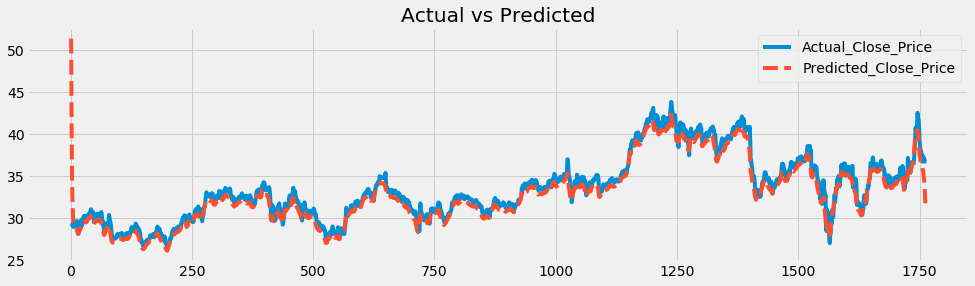

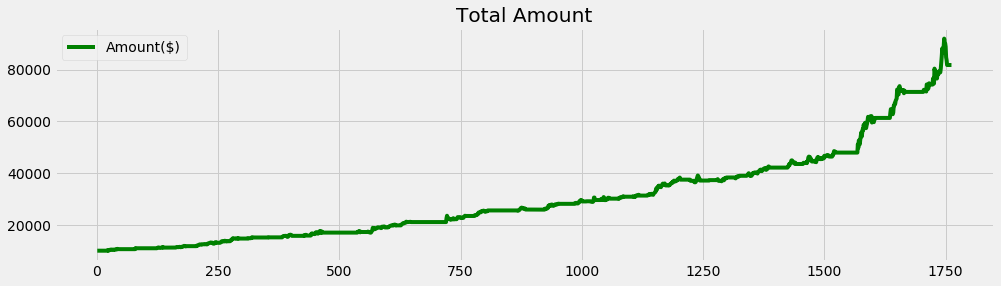

In [38]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [39]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 81799.0 $
Profit_Percent: 817.99 %
